## Generating images

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [12]:
def sample_t(x_0, t, alpha_bars):
    epsilon = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bars[t]) * x_0 + torch.sqrt(1-alpha_bars[t]) * epsilon
    
    return x_t, epsilon

class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        
    def forward(self, t):
            device = t.device
            emb = torch.zeros(t.shape[0], self.embedding_dim, device=device)
            
            for i in range(self.embedding_dim // 2):
                # We ensure the constant is on the correct device too
                const = torch.tensor(10000.0, device=device) 
                omega_i = torch.exp(-(2*i/self.embedding_dim) * torch.log(const))
                
                emb[:, 2*i] = torch.sin(omega_i * t)
                emb[:, 2*i+1] = torch.cos(omega_i * t)
            
            return emb

In [5]:
# 1. Configuration
IMAGE_SIZE = 32
BATCH_SIZE = 128

# 2. Load MNIST Data
# We add padding to make it 32x32 (standard power of 2 is easier for U-Nets)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), 
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale from [0, 1] to [-1, 1]
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100.0%
100.0%
100.0%
100.0%


In [6]:
# 3. Visualize the Forward Process on Images
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2), # Scale back to [0, 1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC for plot
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image), cmap='gray')

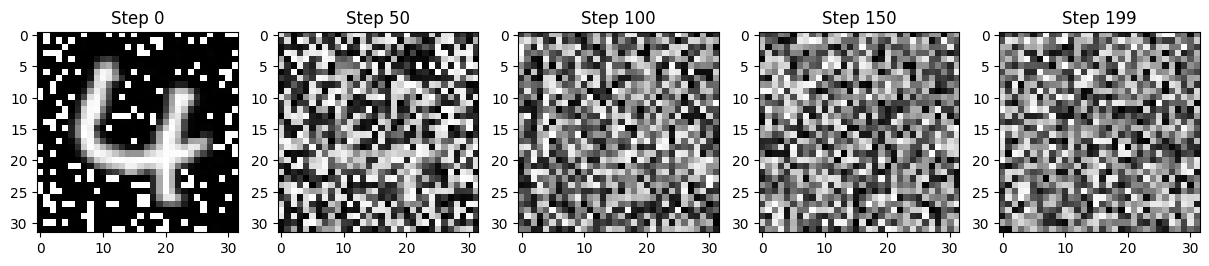

In [7]:
# Let's verify the noise schedule on a digit
# Reuse your existing 'sample_t' function!
images, labels = next(iter(dataloader))
x_0 = images[0:1] # Take the first image

# Timesteps to visualize
steps = [0, 50, 100, 150, 199]
plt.figure(figsize=(15, 3))

# We need your alphas/betas definitions again for 200 steps
betas = torch.linspace(1e-4, 0.02, 200)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

for idx, t in enumerate(steps):
    plt.subplot(1, len(steps), idx + 1)
    # Note: We need to pass t as a tensor
    t_tensor = torch.tensor([t])
    
    # Generate noisy image
    x_t, _ = sample_t(x_0, t_tensor, alpha_bars)
    
    show_tensor_image(x_t)
    plt.title(f"Step {t}")
plt.show()

### U-Net architecture

In [8]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        
        # 1. First Convolution: Change channels (e.g. 1 -> 32)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
        # 2. Time Projection: Map time to match 'out_ch'
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        
        # 3. Second Convolution: Refine features
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
    def forward(self, x, t):
        # First Conv
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu(h)
        
        # Add Time Embedding
        # (Batch, Time_Dim) -> (Batch, Out_Ch) -> (Batch, Out_Ch, 1, 1)
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(..., ) + (None, ) * 2] # Broadcast to 4D
        h = h + time_emb
        
        # Second Conv
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu(h)
        
        return h

In [9]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalEmbedding(32),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        
        # 1. Down Path
        self.down1 = Block(1, 32, 32)
        self.down2 = Block(32, 64, 32)
        self.down3 = Block(64, 128, 32)
        
        self.pool = nn.MaxPool2d(2)
        
        # 2. Bottleneck
        self.bottleneck = Block(128, 256, 32)
        
        # 3. Up Path
        # We separate the Upsampling (ConvTrans) from the Block (Processing)
        
        # Up 1: 4x4 -> 8x8
        self.up_trans1 = nn.ConvTranspose2d(256, 256, 4, 2, 1) 
        self.up1 = Block(256 + 128, 128, 32) # In: Bottle + Skip(x3)
        
        # Up 2: 8x8 -> 16x16
        self.up_trans2 = nn.ConvTranspose2d(128, 128, 4, 2, 1)
        self.up2 = Block(128 + 64, 64, 32)   # In: Prev + Skip(x2)
        
        # Up 3: 16x16 -> 32x32
        self.up_trans3 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.up3 = Block(64 + 32, 32, 32)    # In: Prev + Skip(x1)
        
        # Final projection
        self.final = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t):
        t = self.time_mlp(t)
        
        # --- Down Path ---
        x1 = self.down1(x, t)        # (32, 32, 32)
        x_p1 = self.pool(x1)         # (32, 16, 16)
        
        x2 = self.down2(x_p1, t)     # (64, 16, 16)
        x_p2 = self.pool(x2)         # (64, 8, 8)
        
        x3 = self.down3(x_p2, t)     # (128, 8, 8)
        x_p3 = self.pool(x3)         # (128, 4, 4)
        
        # --- Bottleneck ---
        x = self.bottleneck(x_p3, t) # (256, 4, 4)
        
        # --- Up Path ---
        
        # Step 1: Upsample -> Concat -> Process
        x = self.up_trans1(x)                          # (256, 8, 8)
        x = self.up1(torch.cat((x, x3), dim=1), t)     # (128, 8, 8)
        
        # Step 2
        x = self.up_trans2(x)                          # (128, 16, 16)
        x = self.up2(torch.cat((x, x2), dim=1), t)     # (64, 16, 16)
        
        # Step 3
        x = self.up_trans3(x)                          # (64, 32, 32)
        x = self.up3(torch.cat((x, x1), dim=1), t)     # (32, 32, 32)
        
        return self.final(x)

In [47]:
def load_mnist(image_size=32, batch_size=128, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])
    dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    return dataset, dataloader

In [48]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

dataset, dataloader = load_mnist(image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, device=device)

In [50]:
TIMESTEPS = 300
EPOCHS = 5 

# --- 3. Model & Utils ---
model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Recalculate alphas/betas for the image process
betas = torch.linspace(1e-4, 0.02, TIMESTEPS).to(device)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0).to(device)

In [51]:
def get_noisy_image(x_0, t):
    # This now handles batch of images (B, C, H, W)
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t])[:, None, None, None]
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars[t])[:, None, None, None]
    
    epsilon = torch.randn_like(x_0)
    x_t = sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * epsilon
    return x_t, epsilon

In [52]:
# --- 4. Training Loop ---
print("Starting Training...")
model.train()

for epoch in range(EPOCHS):
    epoch_losses = []
    for step, (images, _) in enumerate(dataloader):
        images = images.to(device)
        
        # 1. Sample timesteps
        t = torch.randint(0, TIMESTEPS, (BATCH_SIZE,), device=device).long()
        
        # 2. Add Noise
        x_t, epsilon = get_noisy_image(images, t)
        
        # 3. Predict Noise
        pred_epsilon = model(x_t, t)
        
        # 4. Optimize
        loss = loss_fn(pred_epsilon, epsilon)
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f}")
    print(f"Average Epoch {epoch} Loss: {sum(epoch_losses) / len(epoch_losses):.4f}")
print("Training Complete!")

Starting Training...
Epoch 0 | Step 0 | Loss: 1.0428
Epoch 0 | Step 100 | Loss: 0.0787
Epoch 0 | Step 200 | Loss: 0.0719
Epoch 0 | Step 300 | Loss: 0.0606
Epoch 0 | Step 400 | Loss: 0.0545
Average Epoch 0 Loss: 0.0809
Epoch 1 | Step 0 | Loss: 0.0687
Epoch 1 | Step 100 | Loss: 0.0543
Epoch 1 | Step 200 | Loss: 0.0483
Epoch 1 | Step 300 | Loss: 0.0416
Epoch 1 | Step 400 | Loss: 0.0534
Average Epoch 1 Loss: 0.0484
Epoch 2 | Step 0 | Loss: 0.0453
Epoch 2 | Step 100 | Loss: 0.0453
Epoch 2 | Step 200 | Loss: 0.0409
Epoch 2 | Step 300 | Loss: 0.0429
Epoch 2 | Step 400 | Loss: 0.0388
Average Epoch 2 Loss: 0.0426
Epoch 3 | Step 0 | Loss: 0.0459
Epoch 3 | Step 100 | Loss: 0.0355
Epoch 3 | Step 200 | Loss: 0.0365
Epoch 3 | Step 300 | Loss: 0.0305
Epoch 3 | Step 400 | Loss: 0.0403
Average Epoch 3 Loss: 0.0397
Epoch 4 | Step 0 | Loss: 0.0429
Epoch 4 | Step 100 | Loss: 0.0309
Epoch 4 | Step 200 | Loss: 0.0345
Epoch 4 | Step 300 | Loss: 0.0358
Epoch 4 | Step 400 | Loss: 0.0319
Average Epoch 4 Loss: 0

In [53]:
@torch.no_grad()
def sample_mnist(model, timesteps, n_samples=16):
    model.eval()
    
    # 1. Start with pure noise (Batch, 1, 32, 32)
    x = torch.randn(n_samples, 1, IMAGE_SIZE, IMAGE_SIZE).to(device)
    
    # 2. Loop backwards
    for t in range(timesteps - 1, -1, -1):
        # Create batch of timesteps
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        
        # Get Model Prediction
        predicted_noise = model(x, t_batch)
        
        # Get constants for this step
        # We reshape them to (1, 1, 1, 1) so they broadcast over the images
        alpha_t = alphas[t].view(1, 1, 1, 1)
        alpha_bar_t = alpha_bars[t].view(1, 1, 1, 1)
        beta_t = betas[t].view(1, 1, 1, 1)
        sigma_t = torch.sqrt(beta_t)
        
        # Algorithm: x_{t-1} = (x_t - ... * pred_noise) / sqrt(alpha)
        if t > 0:
            z = torch.randn_like(x)
        else:
            z = torch.zeros_like(x)
            
        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) + sigma_t * z
        
    return x

Sampling from the model...


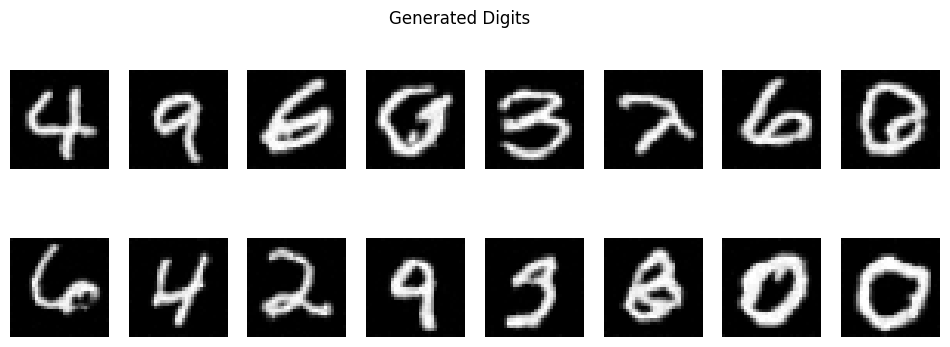

In [62]:
# --- Run the Sampling ---
timesteps = 300
betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0).to(device)

print("Sampling from the model...")
generated_images = sample_mnist(model, timesteps, n_samples=16)

# --- Visualization ---
# Un-normalize from [-1, 1] back to [0, 1]
generated_images = (generated_images + 1) / 2
generated_images = generated_images.clamp(0, 1).cpu()

# Plot as a grid
fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i, 0], cmap='gray')
    ax.axis('off')
plt.suptitle("Generated Digits")
plt.show()

Sampling with recording...
Animated GIF saved to mnist_generation.gif


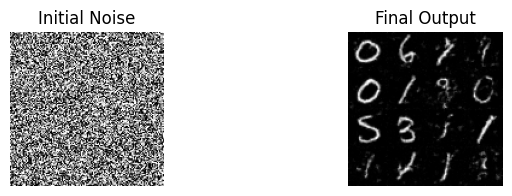

('mnist_generation.gif',
 [<PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=L siz

In [ ]:
from PIL import Image

def generate_mnist_gif(
    model,
    gif_path='mnist_generation.gif',
    timesteps=300,
    n_samples=16,
    grid_size=(4, 4),
    duration=60,
    device=None,
    image_size=None,
    verbose=True,
):
    """
    Generate a diffusion MNIST generation gif from a trained model.

    Args:
        model: The trained (unconditional) model.
        gif_path: Path for saving the gif.
        timesteps: Number of diffusion steps (default: 300).
        n_samples: Number of images for the gif (must match grid_size product).
        grid_size: Tuple (nrow, ncol) for gif grid.
        duration: ms per frame in gif.
        device: torch.device or None (default: model/device autodetect).
        image_size: int or None (default: autodetect from model/x).
        verbose: Print progress and file location.
    """
    import os

    # Setup device and image size
    if device is None:
        device = next(model.parameters()).device
    if image_size is None:
        # Try to get from model or default to 32
        image_size = 32

    # Precompute diffusion schedule
    betas = torch.linspace(1e-4, 0.02, timesteps, device=device)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    @torch.no_grad()
    def sample_with_history(model, steps, samples):
        model.eval()
        x = torch.randn(samples, 1, image_size, image_size, device=device)
        history = []
        for t in range(steps - 1, -1, -1):
            history.append(x.detach().cpu().clone())
            t_batch = torch.full((samples,), t, device=device, dtype=torch.long)
            predicted_noise = model(x, t_batch)
            alpha_t = alphas[t].view(1, 1, 1, 1)
            alpha_bar_t = alpha_bars[t].view(1, 1, 1, 1)
            beta_t = betas[t].view(1, 1, 1, 1)
            sigma_t = torch.sqrt(beta_t)
            z = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
            ) + sigma_t * z
        history.append(x.detach().cpu().clone())
        return history

    def make_grid_img(images, grid_size):
        # images: Tensor [N, 1, H, W], normalized [-1,1] or [0,1]
        imgs = (images + 1) / 2
        imgs = imgs.clamp(0, 1)
        imgs = imgs.cpu().numpy()
        imgs = imgs.squeeze(1)  # [N, H, W]
        nrow, ncol = grid_size
        H, W = imgs.shape[1], imgs.shape[2]
        grid = np.zeros((nrow * H, ncol * W))
        for idx in range(images.shape[0]):
            r = idx // ncol
            c = idx % ncol
            grid[r * H:(r + 1) * H, c * W:(c + 1) * W] = imgs[idx]
        return (grid * 255).astype(np.uint8)

    if verbose:
        print("Sampling with recording...")

    history = sample_with_history(model, timesteps, n_samples)
    frames = [
        Image.fromarray(make_grid_img(step[:n_samples], grid_size=grid_size), mode='L')
        for step in history
    ]

    # Save GIF
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0,
    )
    if verbose:
        print(f"Animated GIF saved to {gif_path}")

    # Optionally display the initial and last generation grids
    plt.figure(figsize=(8, 2))
    plt.subplot(1, 2, 1)
    plt.title("Initial Noise")
    plt.imshow(np.array(frames[0]), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Final Output")
    plt.imshow(np.array(frames[-1]), cmap='gray')
    plt.axis('off')
    plt.show()

    return gif_path, frames

# Example usage (after training your model and defining IMAGE_SIZE/device):
generate_mnist_gif(model,image_size=IMAGE_SIZE, device=device)


### Conditional image generation

In [102]:
class ConditionalUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalEmbedding(32),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        
        self.label_embedding = nn.Embedding(10, 32)
        
        # 1. Down Path
        self.down1 = Block(1, 32, 32)
        self.down2 = Block(32, 64, 32)
        self.down3 = Block(64, 128, 32)
        
        self.pool = nn.MaxPool2d(2)
        
        # 2. Bottleneck
        self.bottleneck = Block(128, 256, 32)
        
        # 3. Up Path
        # We separate the Upsampling (ConvTrans) from the Block (Processing)
        
        # Up 1: 4x4 -> 8x8
        self.up_trans1 = nn.ConvTranspose2d(256, 256, 4, 2, 1) 
        self.up1 = Block(256 + 128, 128, 32) # In: Bottle + Skip(x3)
        
        # Up 2: 8x8 -> 16x16
        self.up_trans2 = nn.ConvTranspose2d(128, 128, 4, 2, 1)
        self.up2 = Block(128 + 64, 64, 32)   # In: Prev + Skip(x2)
        
        # Up 3: 16x16 -> 32x32
        self.up_trans3 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.up3 = Block(64 + 32, 32, 32)    # In: Prev + Skip(x1)
        
        # Final projection
        self.final = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t, label):
        t = self.time_mlp(t)
        label_emb = self.label_embedding(label)
        
        t = t + label_emb
        
        # --- Down Path ---
        x1 = self.down1(x, t)        # (32, 32, 32)
        x_p1 = self.pool(x1)         # (32, 16, 16)
        
        x2 = self.down2(x_p1, t)     # (64, 16, 16)
        x_p2 = self.pool(x2)         # (64, 8, 8)
        
        x3 = self.down3(x_p2, t)     # (128, 8, 8)
        x_p3 = self.pool(x3)         # (128, 4, 4)
        
        # --- Bottleneck ---
        x = self.bottleneck(x_p3, t) # (256, 4, 4)
        
        # --- Up Path ---
        
        # Step 1: Upsample -> Concat -> Process
        x = self.up_trans1(x)                          # (256, 8, 8)
        x = self.up1(torch.cat((x, x3), dim=1), t)     # (128, 8, 8)
        
        # Step 2
        x = self.up_trans2(x)                          # (128, 16, 16)
        x = self.up2(torch.cat((x, x2), dim=1), t)     # (64, 16, 16)
        
        # Step 3
        x = self.up_trans3(x)                          # (64, 32, 32)
        x = self.up3(torch.cat((x, x1), dim=1), t)     # (32, 32, 32)
        
        return self.final(x)

In [140]:
# --- 1. Setup ---
IMAGE_SIZE = 32
BATCH_SIZE = 128


device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

dataset, dataloader = load_mnist(image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, device=device)

In [141]:

TIMESTEPS = 300
EPOCHS = 5 # Start small to verify it runs

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# --- 3. Model & Utils ---
model = ConditionalUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Recalculate alphas/betas for the image process
betas = torch.linspace(1e-4, 0.02, TIMESTEPS).to(device)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0).to(device)

In [ ]:
def get_noisy_image(x_0, t):
    # This now handles batch of images (B, C, H, W)
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t])[:, None, None, None]
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars[t])[:, None, None, None]
    
    epsilon = torch.randn_like(x_0)
    x_t = sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * epsilon
    return x_t, epsilon

# --- 4. Training Loop ---
print("Starting Training...")
model.train()

for epoch in range(EPOCHS):
    epoch_losses = []
    for step, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # 1. Sample timesteps
        t = torch.randint(0, TIMESTEPS, (BATCH_SIZE,), device=device).long()
        
        # 2. Add Noise
        x_t, epsilon = get_noisy_image(images, t)
        
        # 3. Predict Noise
        pred_epsilon = model(x_t, t, labels)
        
        # 4. Optimize
        loss = loss_fn(pred_epsilon, epsilon)
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f}")
    print(f"Average Epoch {epoch} Loss: {sum(epoch_losses) / len(epoch_losses):.4f}")
print("Training Complete!")

In [143]:
@torch.no_grad()
def sample_mnist_conditional(model, timesteps):
    model.eval()
    
    # 1. Start with pure noise (Batch, 1, 32, 32)
    x = torch.randn(10, 1, IMAGE_SIZE, IMAGE_SIZE).to(device)
    
    # Labels 0 to 9
    labels = torch.linspace(0, 9, 10, device=device).long()
    print(labels)
    
    # 2. Loop backwards
    for t in range(timesteps - 1, -1, -1):
        # Create batch of timesteps
        t_batch = torch.full((10,), t, device=device, dtype=torch.long)
        
        # Get Model Prediction
        predicted_noise = model(x, t_batch, labels)
        
        # Get constants for this step
        # We reshape them to (1, 1, 1, 1) so they broadcast over the images
        alpha_t = alphas[t].view(1, 1, 1, 1)
        alpha_bar_t = alpha_bars[t].view(1, 1, 1, 1)
        beta_t = betas[t].view(1, 1, 1, 1)
        sigma_t = torch.sqrt(beta_t)
        
        # Algorithm: x_{t-1} = (x_t - ... * pred_noise) / sqrt(alpha)
        if t > 0:
            z = torch.randn_like(x)
        else:
            z = torch.zeros_like(x)
            
        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) + sigma_t * z
        
    return x

Sampling from the model...
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='mps:0')


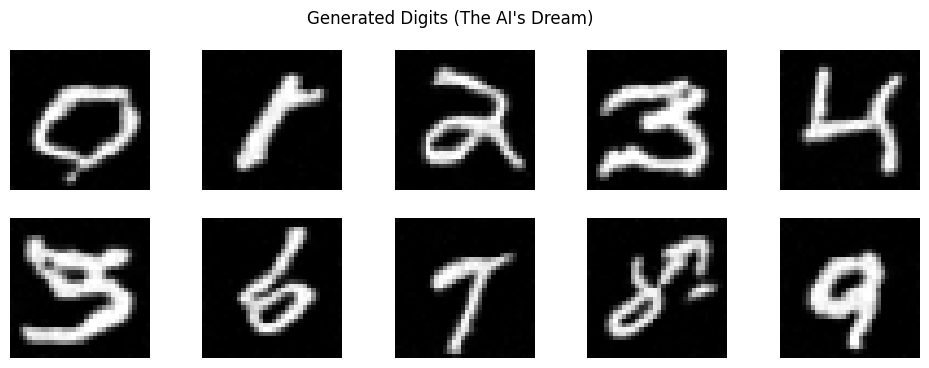

In [148]:
timesteps = 300
# --- Run the Sampling ---
print("Sampling from the model...")
generated_images = sample_mnist_conditional(model, timesteps)

# --- Visualization ---
# Un-normalize from [-1, 1] back to [0, 1]
generated_images = (generated_images + 1) / 2
generated_images = generated_images.clamp(0, 1).cpu()

# Plot as a grid
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i, 0], cmap='gray')
    ax.axis('off')
plt.suptitle("Generated Digits (The AI's Dream)")
plt.show()